This project uses Natural Language Processing to predict if tweets about disasters are real disasters or not.

Dataset from Kaggle
https://www.kaggle.com/competitions/nlp-getting-started/overview

In [ ]:
# From Keras NLP starter guide https://keras.io/guides/keras_nlp/getting_started/
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 12.5 MB/s eta 0:00:00


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
# from keras.preprocessing.text import Tokenizer
import tensorflow as tf
import keras_core as keras
import keras_nlp
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

import warnings
warnings.simplefilter('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend
TensorFlow version: 2.18.0
KerasNLP version: 0.19.1


In [ ]:
# Load data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("/content/drive/MyDrive/projects/NLP_disaster_tweets/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/projects/NLP_disaster_tweets/test.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('df_train shape: {}'.format(df_train.shape))
print('df_test shape: {}'.format(df_test.shape))

df_train shape: (7613, 5)
df_test shape: (3263, 4)


Exploratory Data Analysis

In [ ]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Explore number of real and fake tweets in the training data set. Real will refer to real disasters, and fake will refer to a disaster that is not real.

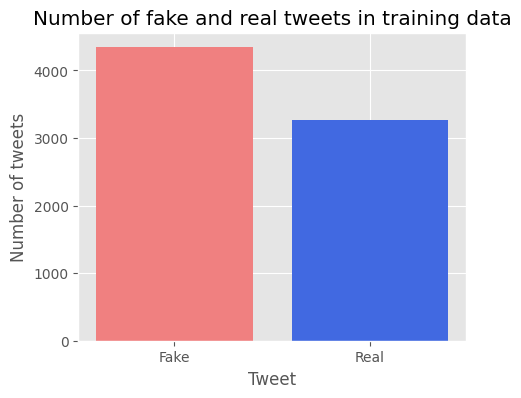

In [ ]:
fake = df_train[df_train['target'] == 0].shape[0]
real = df_train[df_train['target'] == 1].shape[0]

xlabels = ['Fake', 'Real']
ydata = [fake, real]

plt.figure(figsize=(5,4))
plt.bar(xlabels, ydata, color = ('lightcoral','royalblue'))
plt.xlabel('Tweet')
plt.ylabel('Number of tweets')
plt.title('Number of fake and real tweets in training data')
plt.show()



The training data set has a good ratio of fake and real tweets. The class balance is considered mild imbalance.

Explore number of characters in tweets.

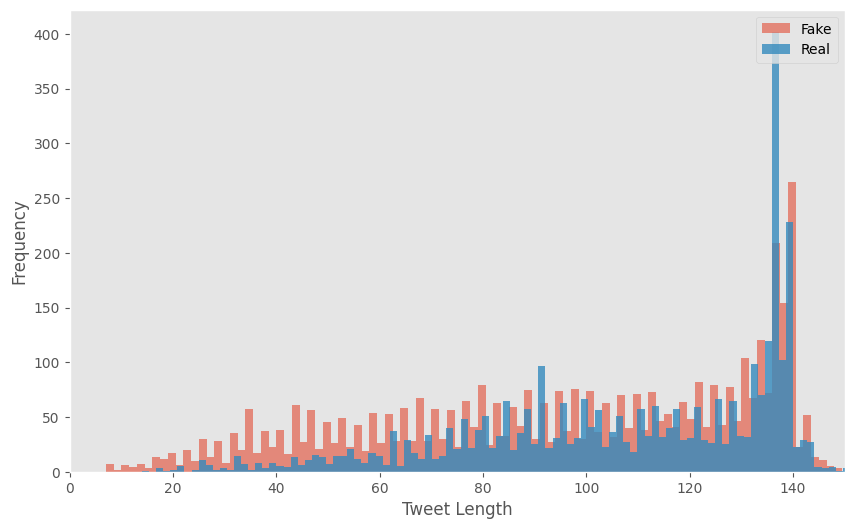

In [ ]:
def length(text):
  return len(text)

df_train['length'] = df_train['text'].apply(length)

plt.figure(figsize=(10,6))
bins = 100
plt.hist(df_train[df_train['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Fake')
plt.hist(df_train[df_train['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

The tweet length distribution is about the same for both fake and real tweets.

Explore number of words in tweets

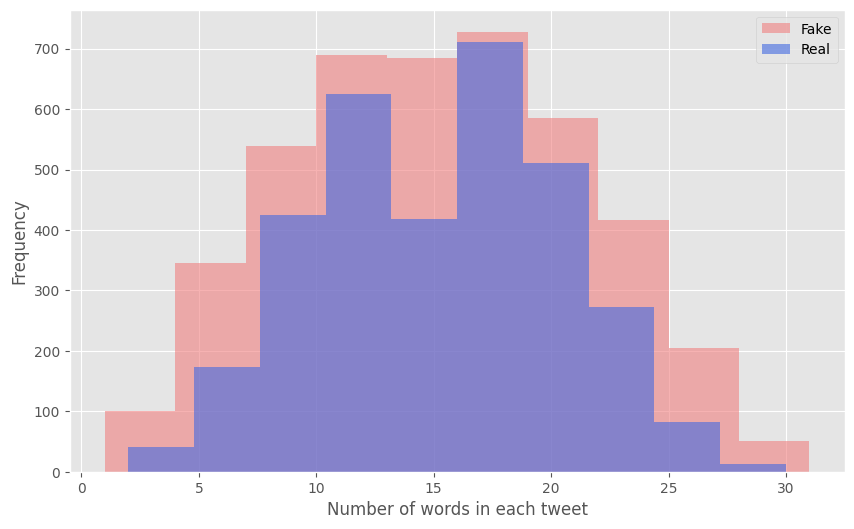

In [ ]:
plt.figure(figsize=(10,6))

bins = 10
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
plt.hist(tweet_len,color='lightcoral', alpha = 0.6, bins=bins, label='Fake')

tweet_len=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
plt.hist(tweet_len,color='royalblue', alpha = 0.6, bins=bins, label='Real')

plt.xlabel('Number of words in each tweet')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

Explore words in tweets

In [ ]:
# Create corpus function
def create_corpus(target):
    corpus = []
    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

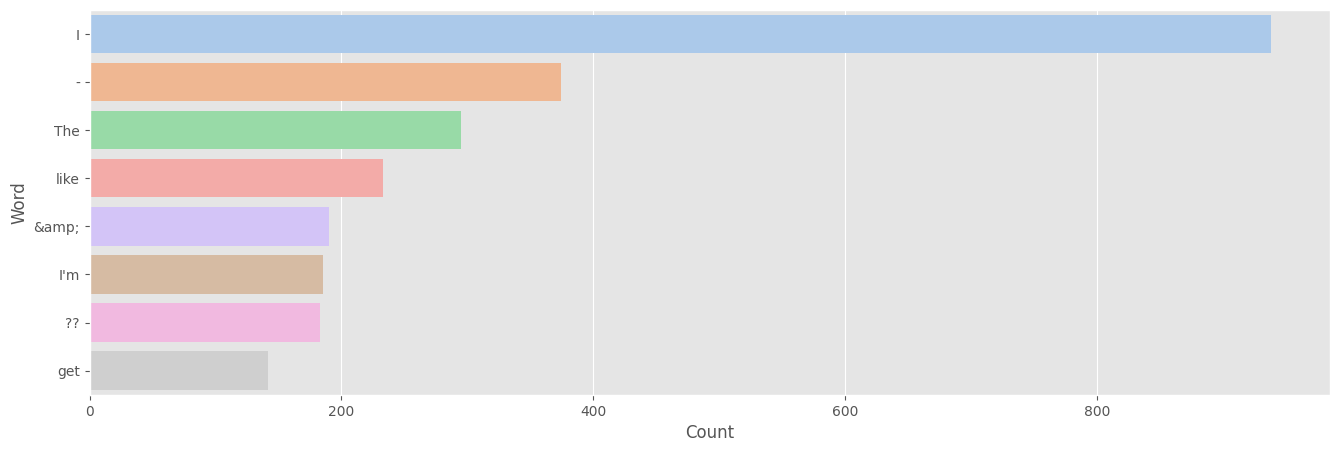

In [ ]:
# Plot most common words in fake tweets
corpus = create_corpus(0)
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(16,5))
sns.barplot(x=y, y=x, palette="pastel")
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


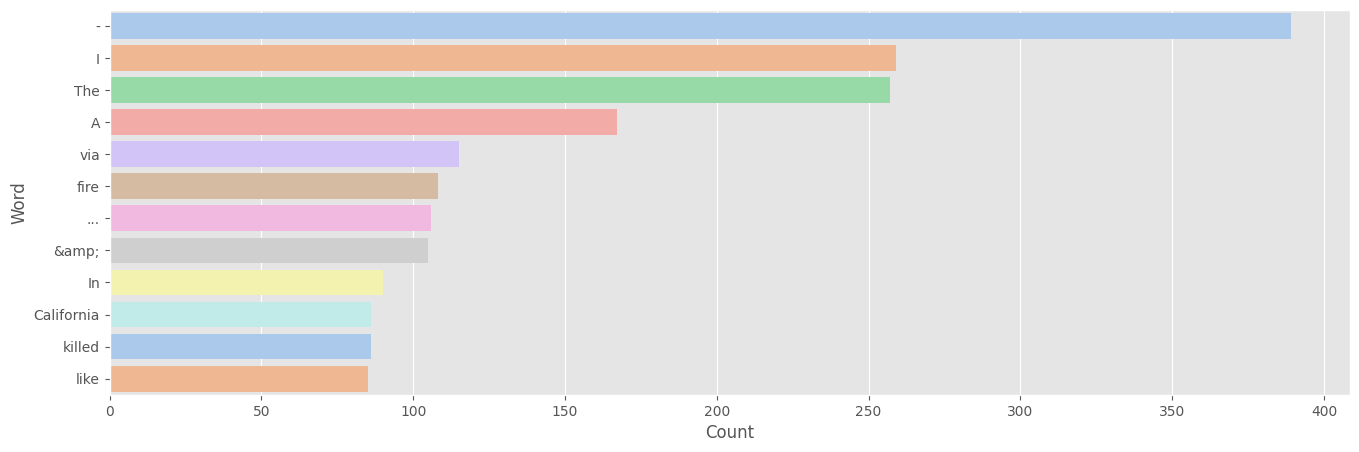

In [ ]:
# Plot most common words in real tweets
corpus = create_corpus(1)
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(16,5))
sns.barplot(x=y, y=x, palette="pastel")
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

Data Cleaning

There are many stop words and punctuation marks which require removal.

In [ ]:
# Remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove html tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove emojis
# Reference https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [ ]:
# Apply removal functions to text
df_train['text'] = df_train['text'].apply(lambda x : remove_URL(x))
df_train['text'] = df_train['text'].apply(lambda x : remove_html(x))
df_train['text'] = df_train['text'].apply(lambda x : remove_emoji(x))
df_train['text'] = df_train['text'].apply(lambda x : remove_punct(x))

Create word clouds

Word cloud for real disaster tweets

In [ ]:
def create_corpus_df(df, target):
    corpus = []
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
corpus_real = create_corpus_df(df_train, 1)

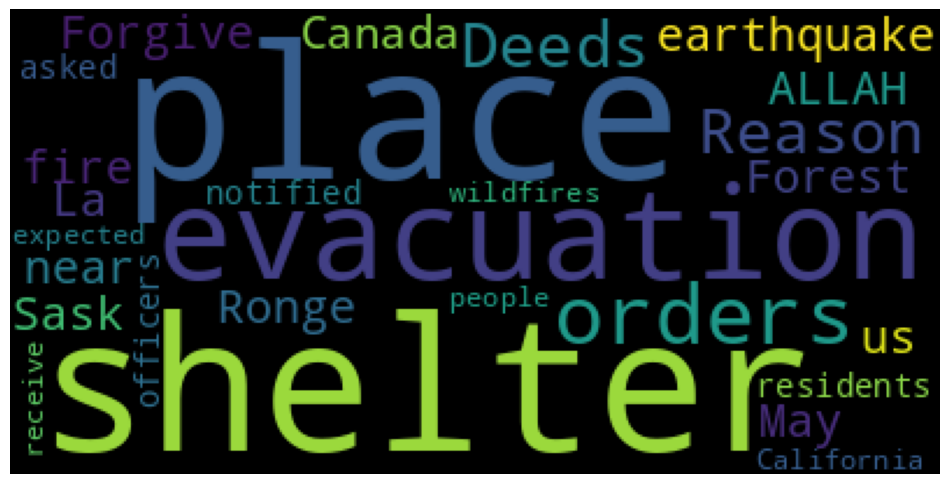

In [ ]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_real[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
corpus_fake = create_corpus_df(df_train, 0)

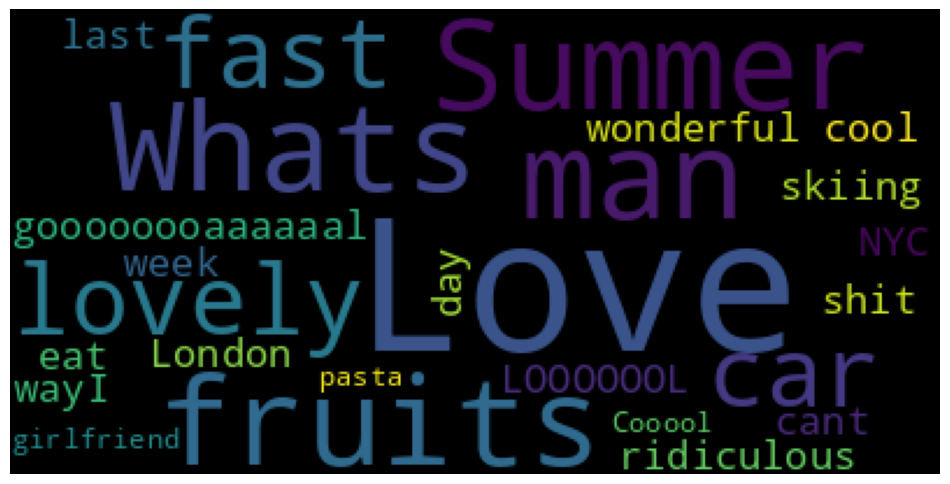

In [ ]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_fake[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
# Apply removal functions to test text for future use
df_test['text'] = df_test['text'].apply(lambda x : remove_URL(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_html(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_emoji(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_punct(x))

Feature engineering: Use text and target. Keyword and location contain many missing values.

Modeling: Use KerasNLP

Reference: https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE)

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE


Separate training df into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

print('df_train shape: {}'.format(df_train.shape))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

df_train shape: (7613, 6)


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

loss_function = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=1e-5)

# Compile
classifier.compile(
    loss = loss_function,
    optimizer = optimizer,
    metrics= ["accuracy"]
)

In [ ]:
# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
190/190 ━━━━━━━━━━━━━━━━━━━━ 9170s 48s/step - accuracy: 0.7353 - loss: 0.5583 - val_accuracy: 0.8359 - val_loss: 0.3983
Epoch 2/2
190/190 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - accuracy: 0.7000 - loss: 0.4739 - val_accuracy: 0.8365 - val_loss: 0.3985


In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Fake","Real"],
        cmap=plt.cm.Blues,
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
y_pred_train = classifier.predict(X_train)

191/191 ━━━━━━━━━━━━━━━━━━━━ 2152s 11s/step


In [ ]:
print(len(y_train))
print(len(y_pred_train))

6090
6090


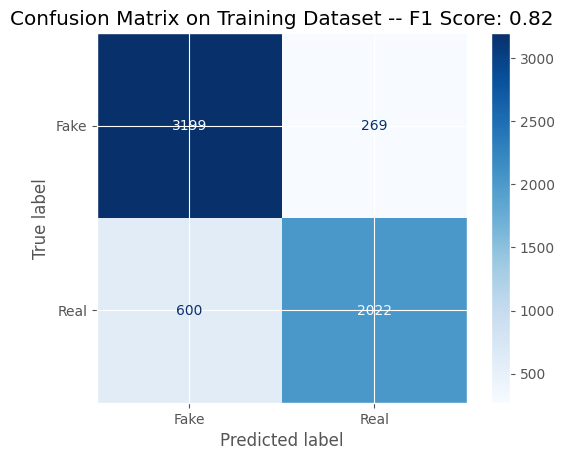

In [ ]:
displayConfusionMatrix(y_train, y_pred_train, "Training")

In [ ]:
y_pred_val = classifier.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 546s 11s/step


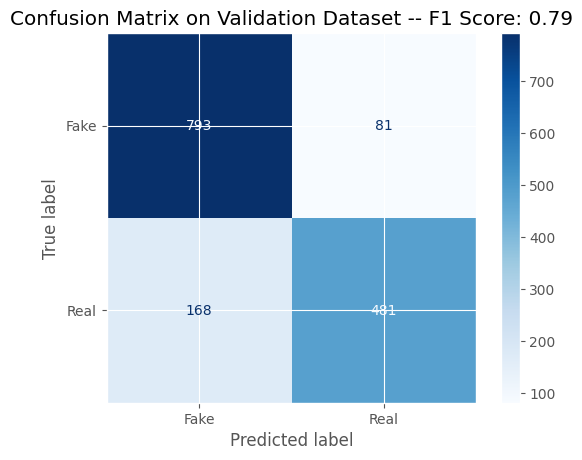

In [ ]:
displayConfusionMatrix(y_val, y_pred_val, "Validation")

Create submission file

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/projects/NLP_disaster_tweets/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1170s 11s/step


In [ ]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.366534
std,3146.427221,0.481931
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [ ]:
sample_submission.to_csv("submission.csv", index=False)